## Practical part

- Engagement:
     - Calculate retention and time that players spend in the game.
     - How players advance through levels.
     - How players progress through quests.
- Monetization:
     - Calculate overall monetization rates for a cohort
     - Show where players make their first payments
     - Show where players make the most payments

## Practical part (solution)

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect('test.db') 

In [3]:
data = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", con)

In [4]:
data

,name
0,level_up
1,payment
2,quest_complete
3,quest_start
4,session_close
5,install


In [5]:
level_up =  pd.read_sql("SELECT * FROM level_up", con)
payment = pd.read_sql("SELECT * FROM payment", con)
quest_complete = pd.read_sql("SELECT * FROM quest_complete", con)
quest_start = pd.read_sql("SELECT * FROM quest_start", con)
session_close = pd.read_sql("SELECT * FROM session_close", con)
install = pd.read_sql("SELECT * FROM install", con)      

Convert some columns to datetime

In [6]:
dt_format = '%Y-%m-%d %H:%M:%S'

In [7]:
install['reg_time'] = pd.to_datetime(pd.to_datetime(install['reg_time']).dt.strftime(dt_format))
payment['time'] = pd.to_datetime(pd.to_datetime(payment['time']).dt.strftime(dt_format))
session_close['open_time'] = pd.to_datetime(pd.to_datetime(session_close['open_time']).dt.strftime(dt_format))
session_close['close_time'] = pd.to_datetime(pd.to_datetime(session_close['close_time']).dt.strftime(dt_format))

In [8]:
time_in_game = session_close.groupby('user_id').agg({'open_time':'min', 'close_time':'max'})
all_time_in_game = time_in_game['close_time'] - time_in_game['open_time']

## Engagement analysis

### DAU - the number of players who entered the game at least once a day

[Text(0.5, 1.0, 'DAU'), Text(0, 0.5, 'count players'), Text(0.5, 0, 'date')]

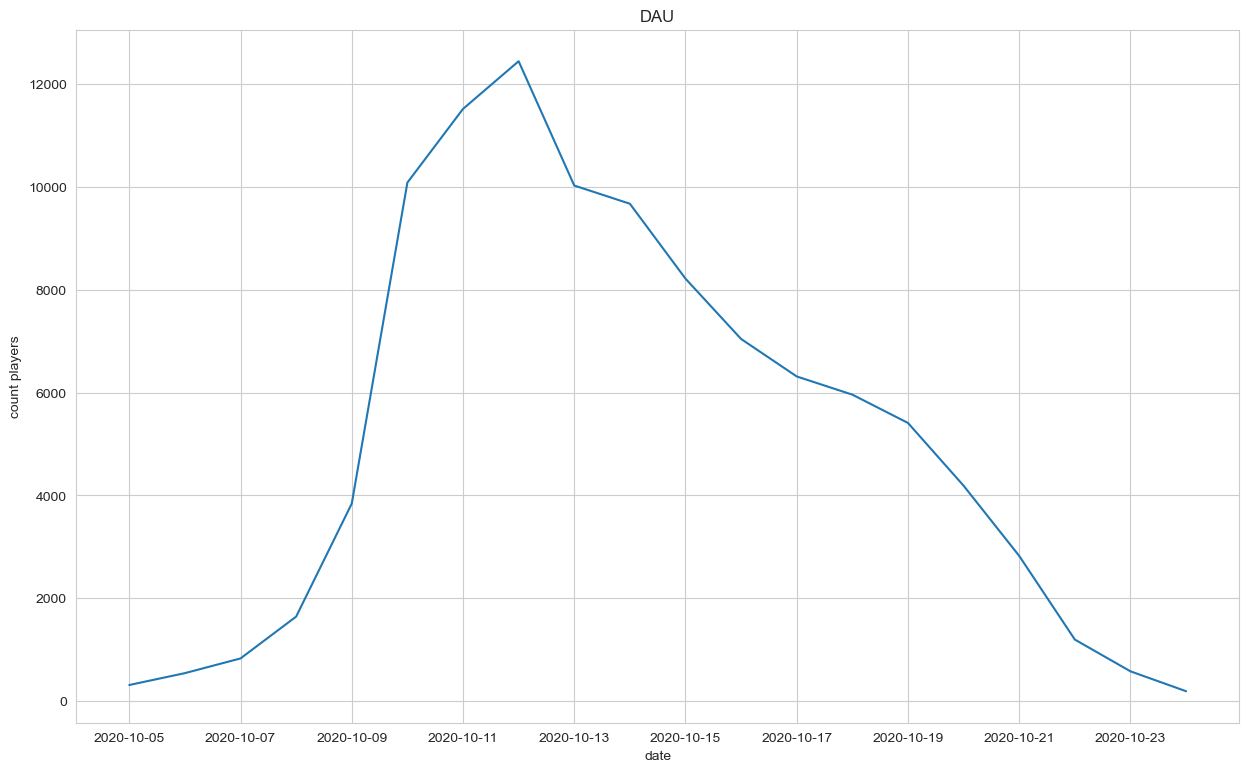

In [16]:
dau = session_close.groupby(pd.Grouper(key='open_time', freq='D'))['user_id'].nunique()
plt.figure(figsize=(15,9), dpi=100)
sns.set_style('whitegrid')
sns.lineplot(data=dau, x="open_time", y=dau.values).set(title="DAU", ylabel='count players', xlabel='date')

### WAU - the number of players who logged into the game at least once a week

open_time
2020-10-11    21384
2020-10-18    17926
2020-10-25     6306
Freq: W-SUN, Name: user_id, dtype: int64

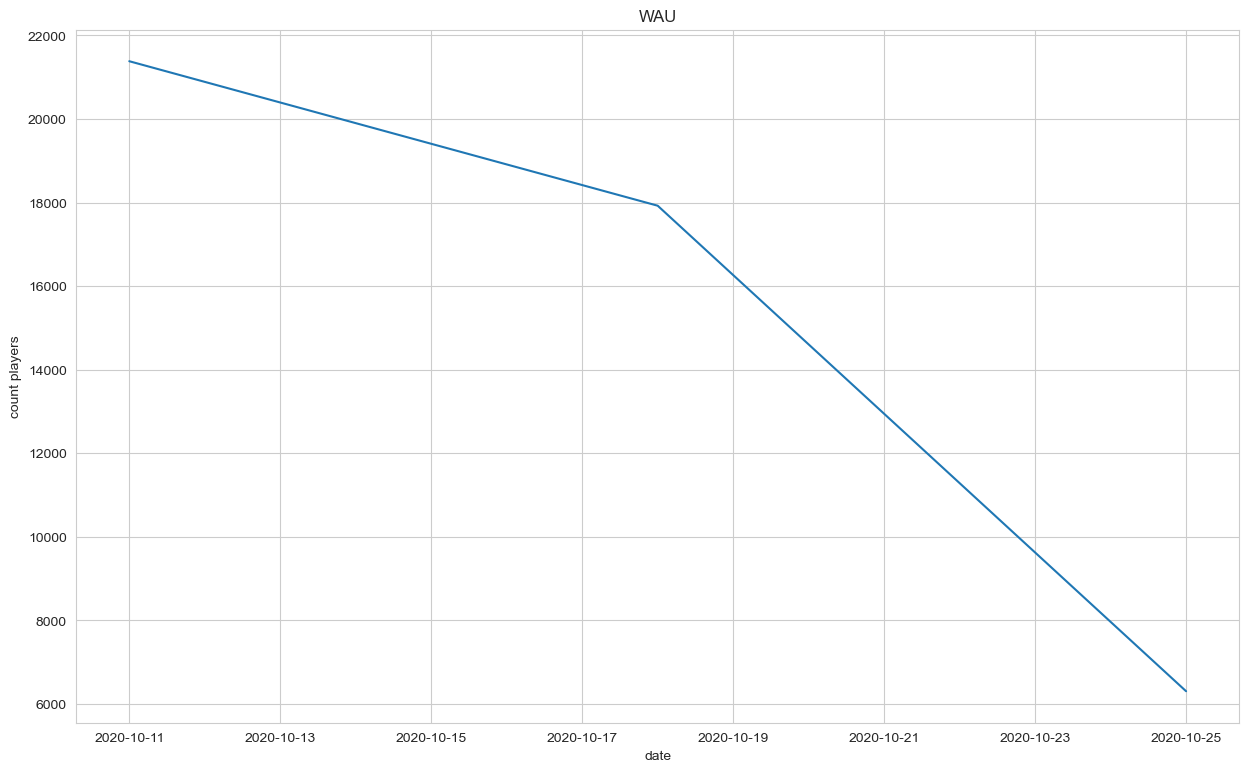

In [17]:
wau = session_close.groupby(pd.Grouper(key='open_time', freq='W'))['user_id'].nunique()
plt.figure(figsize=(15,9), dpi=100)
sns.set_style('whitegrid')
sns.lineplot(data=wau, x="open_time", y=wau.values).set(title="WAU", ylabel='count players', xlabel='date')
wau

### Time of all sessions

In [18]:
all_time_sessions = session_close.groupby('user_id')['duration'].sum()

### Number of sessions

In [19]:
session_count = session_close.groupby('user_id')['close_time'].count()

### Average game session duration (in seconds)

In [20]:
duration = session_close.groupby(['user_id'])['duration']
duration.median().median()

422.917

### Number of days the user logged into the game

[Text(0, 0.5, 'count players'),
 Text(0.5, 0, 'amount of days'),
 Text(0.5, 1.0, 'Number of days the user logged into the game')]

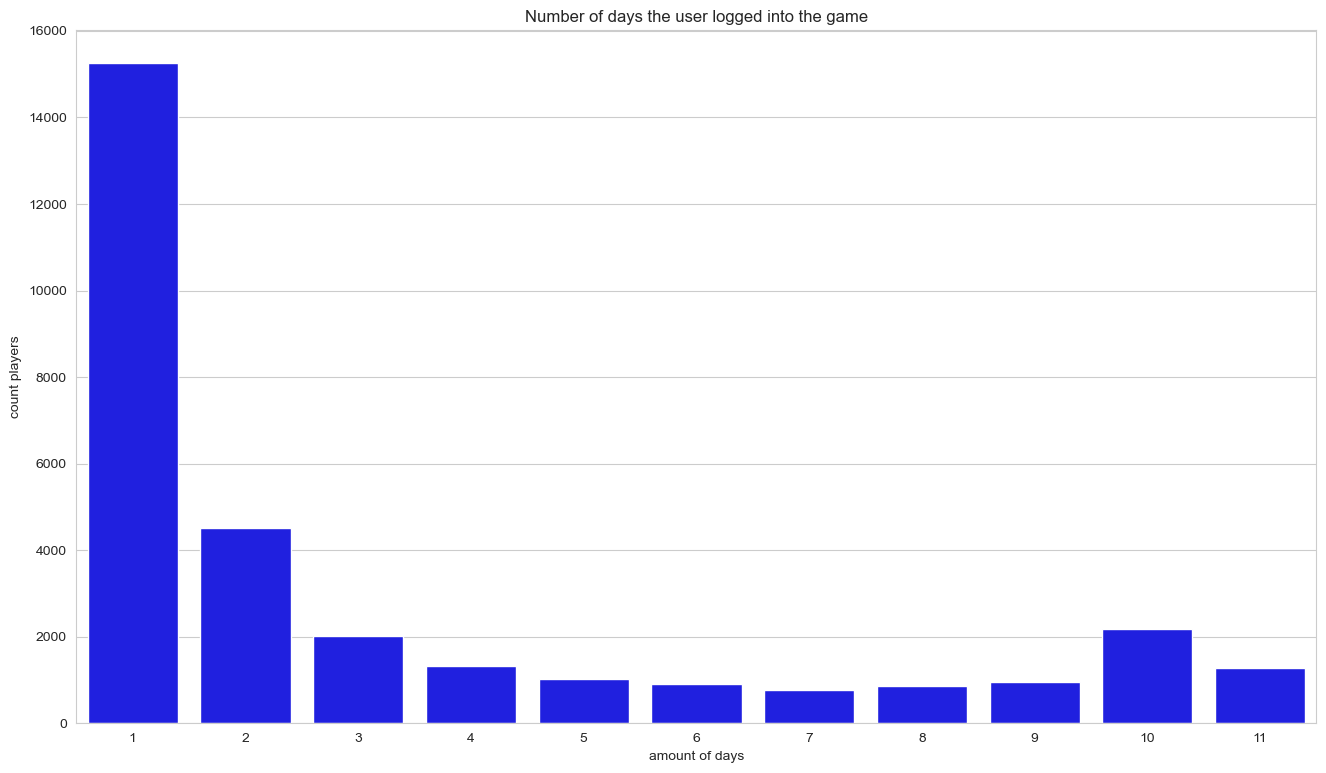

In [38]:
session_close['open_date'] = session_close['open_time'].dt.date
amount_of_days = session_close.groupby('user_id')['open_date'].nunique()
df_dg = pd.DataFrame(data=amount_of_days.values, columns=['amount_of_days'])
plt.figure(figsize=(16,9), dpi=100)
sns.set_style('whitegrid')
sns.countplot(x='amount_of_days', data=df_dg, color='blue').set(ylabel='count players', 
                                                                xlabel='amount of days', 
                                                                title='Number of days the user logged into the game')

### Sticky Factor - audience activity

#### Sticky Factor = DAU / MAU * 100%

In [22]:
of_week = session_close.groupby([pd.Grouper(key='open_time', freq='W'),pd.Grouper(key='open_time', freq='D')])['user_id'].nunique().mean(level=0)
sticky_factor = of_week.mean(level=0)/wau
sticky_factor

C:\Users\polon\AppData\Local\Temp\ipykernel_18912\3850762380.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  of_week = session_close.groupby([pd.Grouper(key='open_time', freq='W'),pd.Grouper(key='open_time', freq='D')])['user_id'].nunique().mean(level=0)
C:\Users\polon\AppData\Local\Temp\ipykernel_18912\3850762380.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  sticky_factor = of_week.mean(level=0)/wau


open_time
2020-10-11    0.192213
2020-10-18    0.475710
2020-10-25    0.380167
Name: user_id, dtype: float64

### Retention

### (number of users who entered the product on day N)/(number of users who entered the product N days ago)∙100%

[0.9981359472923027, 0.38981198778724085, 0.3081471958862285, 0.26813434035031336, 0.23917724570143017, 0.21802988912100274, 0.20385666077454603, 0.19752530933633297, 0.185633938614816]


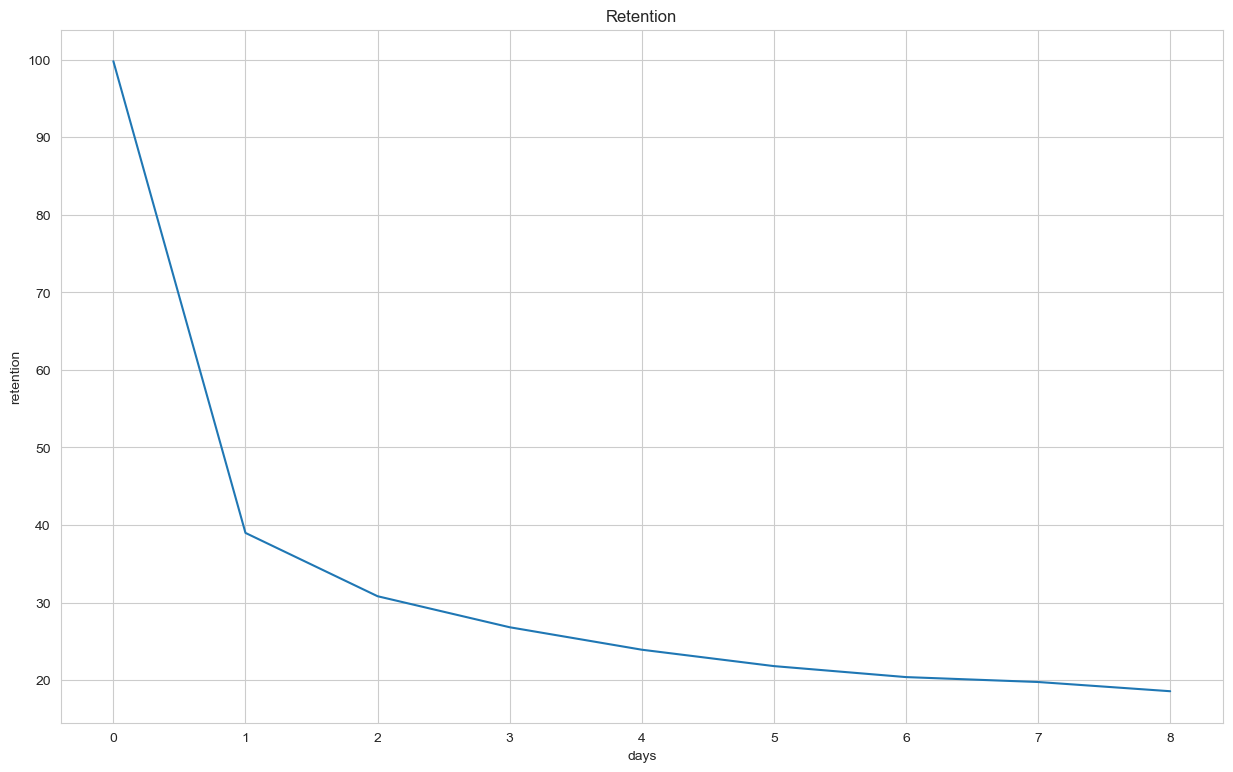

In [39]:
session_close = session_close.merge(install[['user_id','reg_time']], how='left')

session_close['first_day'] = session_close['reg_time'].dt.date

# сколько прошло времени между регистрацией и сессией пользователя
session_close['delta_t'] = session_close['open_time'] - session_close['reg_time'] 
session_close['n_day'] = session_close['delta_t'].dt.days

# количество пользователей n-ого дня
count_n_day_users = session_close.groupby('n_day')['user_id'].nunique()
date_countdown = session_close['close_time'].max()

# кольчество дней с момента регистрации
install['days_since_reg'] = (date_countdown - install['reg_time']).dt.days
retention = [count_n_day_users[nday] / install.loc[install['days_since_reg'] >= nday, 'user_id'].nunique() 
             for nday in range(count_n_day_users.index.max())]

df_retention = pd.DataFrame(data=retention, columns=['retention'])
df_retention['days'] = df_retention.index
df_retention['retention'] = df_retention['retention'] * 100

plt.figure(figsize=(15,9), dpi=100)
sns.set_style('whitegrid')
sns.lineplot(data=df_retention, x="days", y="retention").set(title="Retention", ylabel='retention')
print(retention)

## Monetization analysis

### Gross Revenue - the total amount of money that players paid

In [31]:
gross_revenue = payment['amount'].sum()
gross_revenue

381.73969465648855

### Paying Share - the percentage of players who buy something from the total number of players

In [32]:
paying_players = payment['user_id'].nunique()
paying_share = paying_players / install['user_id'].nunique()
format(paying_share, '0.00')

'0.01'

### ARPDAU - daily income / daily active users

[Text(0.5, 1.0, 'ARPDAU'), Text(0.5, 0, 'date'), Text(0, 0.5, 'revenue')]

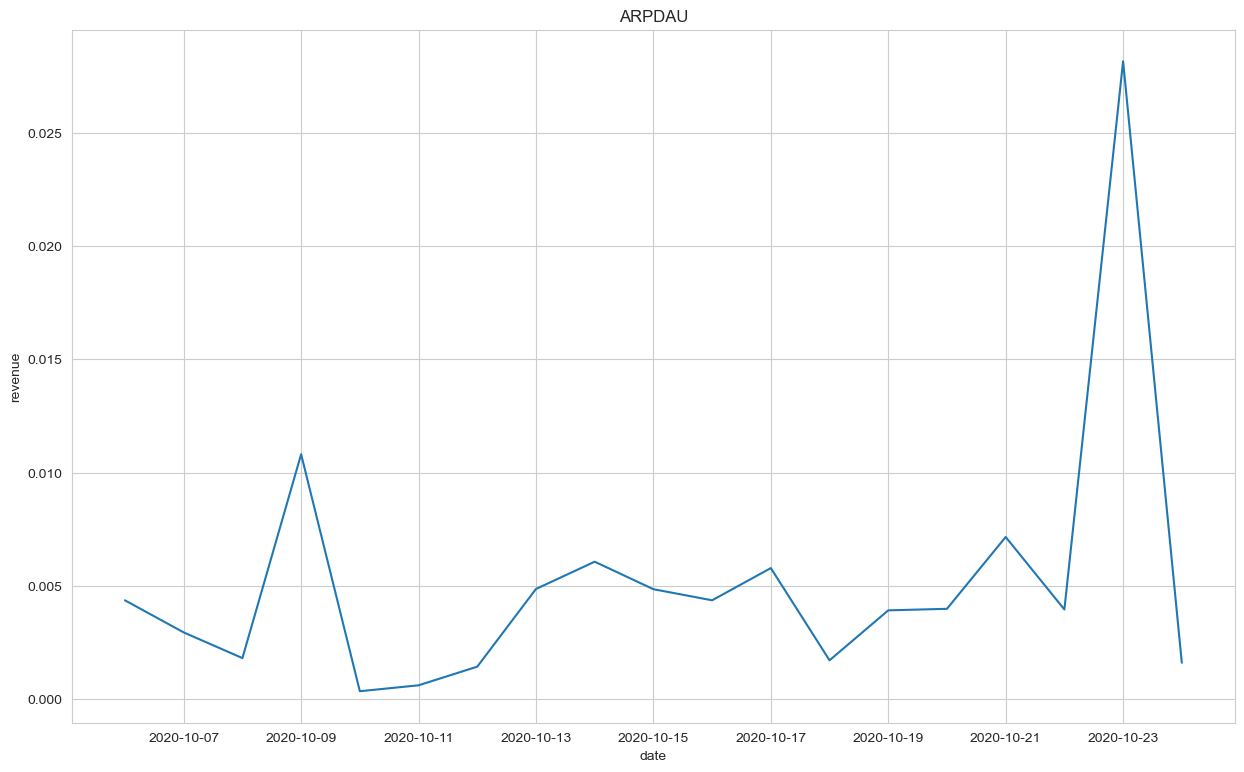

In [33]:
day_amount = payment.groupby(pd.Grouper(key='time', freq='D'))['amount'].sum()
arpdau = day_amount / dau
df_arpdau = pd.DataFrame(data=arpdau, columns=['value'])
plt.figure(figsize=(15,9), dpi=100)
sns.set_style('whitegrid')
sns.lineplot(data=arpdau, x=arpdau.index, y=arpdau.values).set(title="ARPDAU", xlabel='date', ylabel='revenue')

### LTV - shows how much each user will ultimately spend in the application

#### average number of sales for 1 period * average bill * number of periods of user life

[Text(0.5, 1.0, 'LTV'), Text(0.5, 0, 'days'), Text(0, 0.5, 'amount')]

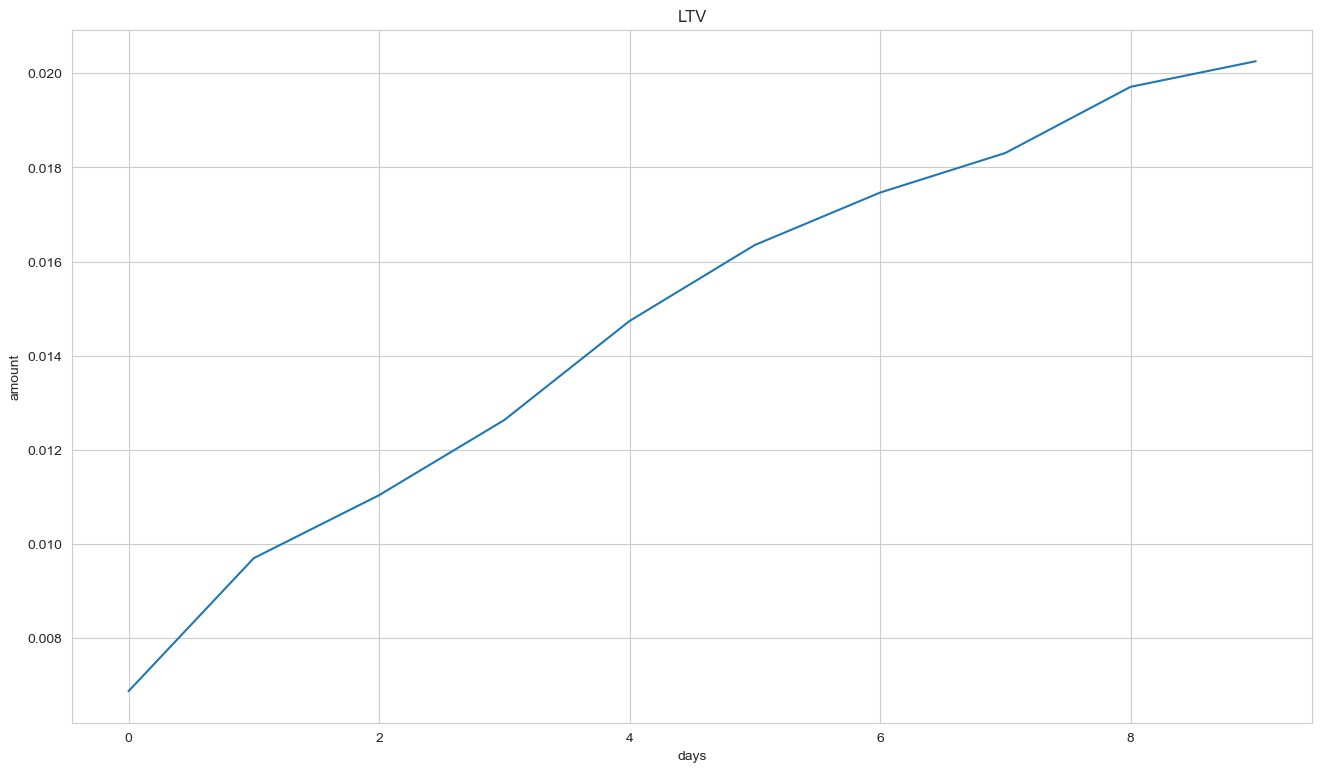

In [40]:
payment = payment.merge(install[['user_id','reg_time']], how='left')
payment['days_since_reg'] = (payment['time'] - payment['reg_time']).dt.days

amount_per_day = payment.groupby('days_since_reg').sum().cumsum()
pivot = payment.pivot_table(values='amount', index=pd.Grouper(key='reg_time', freq='D'), 
                            columns='days_since_reg', aggfunc='sum', fill_value=0).cumsum(axis=1)

reg_per_day = install.groupby(pd.Grouper(key='reg_time', freq='D'))['user_id'].nunique()
reg_per_day.name = 'new_players'

ltv = pivot.div(reg_per_day,axis=0).mean(axis=0)
plt.figure(figsize=(16,9), dpi=100)
sns.set_style('whitegrid')

sns.lineplot(data=ltv, x=ltv.index, y=ltv.values).set(title="LTV", xlabel='days', ylabel='amount')

# Conclusions

### When analyzing engagement, it turned out that:

#### 1. When calculating retention, it turned out that 18% of users entered the game on day 10

#### 2. The average duration of a session in the game is 422 seconds, that’s 7 minutes

### When analyzing monetization, it turned out that:

#### 1. 1% of users began to pay for something in the game

#### 2. October 9 and 23 there is a jump in ARPDAU

#### 3. The LTV indicator is growing steadily, but it is unknown whether it will continue or stop

## Expanded list of main events

1. place_close(user_id, time_close, ID_place) - at what level players close the game.

2. train_complete(user_id, progress) - whether the player has completed the training.

3. store_tracker(product_id, user_id) - how users buy products in the game.

4. resources_over(user_id, type_resource) - whether the user has run out of resources.

## Strategy for further analysis based on the events I have proposed.

most likely, when players run out of energy, they quit the game or buy it. Count the number of players who have run out of energy.

count the number of users who bought something during the promotion, perhaps participated in a game event.

analyze users who entered the store, clicked on buttons in the store (buy or leave the store). Why I didn’t buy it, what were the reasons?

count the number of users who completely completed the training to find out whether the quality of training is related to user interest.

count the number of users when they most often left the game to find out whether a particular event is related to the player’s interest.